In [1]:
import tensorflow as tf
import numpy as np
import os

from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping, TensorBoard

physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("this happened")

this happened


import pickle

folder = 'pure_amd_pickled'

pickle_in = open(folder + '/' + 'ODIR_AMD_w_others_pred.pickle','rb')
ODIR_AMD_w_others = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'ODIR_Pure_AMD_pred.pickle','rb')
ODIR_Pure_AMD = pickle.load(pickle_in)

# pickle_in = open(folder + '/' + 'ODIR_Normal_pred.pickle','rb')
# ODIR_normal = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'RFMID_AMD_w_others_pred.pickle','rb')
RFMID_AMD_w_others = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'RFMID_Pure_AMD_pred.pickle','rb')
RFMID_Pure_AMD = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'RFMID_normal_pred.pickle','rb')
RFMID_normal = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'stare_AMD_w_others_pred.pickle','rb')
stare_AMD_w_others = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'stare_normal_pred.pickle','rb')
stare_normal = pickle.load(pickle_in)

# pickle_in = open(folder + '/' + 'RFMiD_AMD_w_others_testing_pred.pickle','rb')
# RFMID_AMD_w_others_test = pickle.load(pickle_in)

# pickle_in = open(folder + '/' + 'RFMiD_Pure_AMD_testing_pred.pickle','rb')
# RFMID_Pure_AMD_test = pickle.load(pickle_in)

# pickle_in = open(folder + '/' + 'RFMiD_normal_testing_pred.pickle','rb')
# RFMID_normal_test = pickle.load(pickle_in)

In [2]:
import pickle

folder = 'clahe'

pickle_in = open(folder + '/' + 'ODIR_AMD_w_others_data.pickle','rb')
ODIR_AMD_w_others = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'ODIR_Pure_AMD_data.pickle','rb')
ODIR_Pure_AMD = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'ODIR_Normal_data.pickle','rb')
ODIR_normal = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'RFMID_AMD_w_others_data.pickle','rb')
RFMID_AMD_w_others = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'RFMID_Pure_AMD_data.pickle','rb')
RFMID_Pure_AMD = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'RFMID_normal_data.pickle','rb')
RFMID_normal = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'stare_AMD_w_others_data.pickle','rb')
stare_AMD_w_others = pickle.load(pickle_in)

pickle_in = open(folder + '/' + 'stare_normal_data.pickle','rb')
stare_normal = pickle.load(pickle_in)

In [3]:
# Get the dimensions of the image
height, width, channels = ODIR_AMD_w_others[0].shape

# Print the dimensions
print("Width:", width)
print("Height:", height)
print("Channels:", channels)

Width: 512
Height: 512
Channels: 1


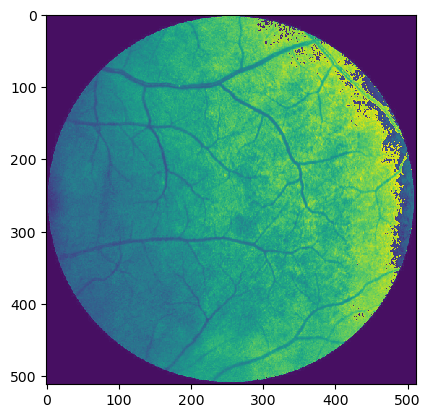

In [4]:
from matplotlib import pyplot as plt
plt.imshow(stare_normal[1], interpolation='nearest')
plt.show()

In [5]:
print('amd = ', len(ODIR_Pure_AMD[:160]) + len(RFMID_AMD_w_others))
print('normal = ', len(RFMID_normal))

amd =  292
normal =  290


In [6]:
segmented_amd_mixed = np.concatenate((ODIR_Pure_AMD[:160], RFMID_AMD_w_others), axis=0)
#segmented_pure_amd = np.concatenate((ODIR_Pure_AMD, RFMID_Pure_AMD), axis=0)
#segmented_amd_w_others = np.concatenate((ODIR_AMD_w_others, RFMID_AMD_w_others, stare_AMD_w_others), axis=0)
segmented_normal = RFMID_normal

# segmented_amd_test = np.concatenate((RFMID_AMD_w_others_test, RFMID_Pure_AMD_test), axis=0)
# segmented_normal_test = RFMID_normal_test[:138]

In [7]:
print('amd:', len(segmented_amd_mixed))
print('normal:', len(segmented_normal))

amd: 292
normal: 290


In [8]:
y_amd = []
y_normal = []

for i in range(len(segmented_amd_mixed)):
    y_amd.append(1)

for i in range(len(segmented_normal)):
    y_normal.append(0)

label_amd = np.array(y_amd)
label_normal = np.array(y_normal)

y_amd_test = []
y_normal_test = []

for i in range(len(segmented_amd_test)):
    y_amd_test.append(1)

for i in range(len(segmented_normal_test)):
    y_normal_test.append(0)

label_amd_test = np.array(y_amd_test)
label_normal_test = np.array(y_normal_test)

In [9]:
x = np.concatenate((segmented_amd_mixed, segmented_normal), axis=0)
y = np.concatenate((label_amd, label_normal), axis=0)

x_test = np.concatenate((segmented_amd_test, segmented_normal_test), axis=0)
y_test = np.concatenate((label_amd_test, label_normal_test), axis=0)

In [10]:
from sklearn.model_selection import train_test_split

x_train, alpha, y_train, omega = train_test_split(x, y, test_size=0.2, random_state=1)
x_eval, x_test, y_eval, y_test = train_test_split(alpha, omega, test_size=0.5, random_state=1)

In [11]:
# Define the input shape
input_shape = (512, 512, 1)

# Define the model
model = tf.keras.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Second convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Flatten the output of the convolutional layers
    tf.keras.layers.Flatten(),
    # First fully connected layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                        

In [13]:
# Define the batch size and number of epochs for training
batch_size = 4
epochs = 100
model_filename = 'pass_models/model_mixed_clahe_v1.h5'
callback_checkpoint =[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=False),
ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-7, verbose=1),
TensorBoard()]

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_eval.shape)
print(y_eval.shape)

(465, 512, 512, 1)
(465,)
(58, 512, 512, 1)
(58,)


In [15]:
# with tf.device("GPU"):
#     model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_eval, y_eval),
#         callbacks=[callback_checkpoint])

In [16]:
model.evaluate(x_test, y_test, batch_size=4)

15/15 [==============================] - 3s 36ms/step - loss: 0.6915 - accuracy: 0.5085


[0.6914750933647156, 0.508474588394165]

# Testing the Model | Creating Predictions

In [17]:
model_filename = 'pass_models/model_mixed_clahe_v1.h5'
model.load_weights(model_filename)
with tf.device("GPU"): 
    result = model.predict(x_test)

# set a threshold value (e.g., 0.5)
threshold = 0.5

# convert the probability scores to binary class labels
predictions = np.where(result > threshold, 1, 0).flatten()
print('Predictions: ', predictions)

2/2 [==============================] - 4s 2s/step
Predictions:  [0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 0
 0 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0]


In [18]:
import pandas as pd

data = { 'Actual': y_test, 'Predicted': predictions }
preds = pd.DataFrame(data)

preds

,Actual,Predicted
0,1,0
1,1,1
2,0,0
3,0,1
4,1,1
5,1,1
6,0,0
7,0,1
8,1,1
9,1,1


In [19]:
correctly_pred = (preds['Actual'] == preds['Predicted']).sum()
print(f'{correctly_pred} out of {len(preds)} were correctly predicted')
print(f'{(correctly_pred/len(preds))*100}% is your score')

49 out of 59 were correctly predicted
83.05084745762711% is your score


In [20]:
tpos = 0
tneg = 0
fpos = 0
fneg = 0

for i in range(len(preds)):
    if preds['Actual'][i] == 1 and preds['Predicted'][i] == 1:
        tpos+=1
    elif preds['Actual'][i] == 1 and preds['Predicted'][i] == 0:
        fneg+=1
    elif preds['Actual'][i] == 0 and preds['Predicted'][i] == 0:
        tneg+=1
    elif preds['Actual'][i] == 0 and preds['Predicted'][i] == 1:
        fpos+=1

In [21]:
precision = (tpos/(tpos+fpos))
recall = (tpos/(tpos+fneg))
accuracy = ((tpos+tneg)/(tpos+tneg+fpos+fneg))
fone = 2*((precision*recall)/(precision+recall))

In [22]:
print('Precision: {}%'.format(round(precision*100, 2)))
print('Recall: {}%'.format(round(recall*100, 2)))
print('Accuracy: {}%'.format(round(accuracy*100, 2)))
print('F1-Score: {}%'.format(round(fone*100, 2)))

Precision: 83.33%
Recall: 83.33%
Accuracy: 83.05%
F1-Score: 83.33%
